### **RISCO DE FOGO: QUEIMADAS NO CERRADO**
<hr>
<p align="justify">
Este trabalho é referente as tarefas desenvolvidas no Bloco 1. Espera-se desenvolver um projeto capaz de utilizar os comandos aprendidos pela linguagem de programação Python, na disciplina de Aprendizado de Máquina, além de desenvolver um sistema de previsão através de Machine Learning. O grupo desenvolvedor é composto pelas discentes:
<p align="justify">
Isabela Bento Beneti </p>
<p align="justify">
Monyque Karoline de Paula Silva </p>
<p align="justify">
Sofia Baccega C.C. de Oliveira </p>
<p align="justify">
Sophia Figueiredo Michel </p>
<hr>

### **Início:**
<p align="justify">
Em um primento momento, iremos demonstrar o processo de tratamento dos dados obtidos via Database do INPE a respeito dos focos de incêndio ocorridos no Cerrado durante o período Janeiro-Julho(2022). É necessário realizar as padronizações de bibliotecas inicias, como a Pandas, Seaborn e Matplotlib, posteriormente, trabalha-se os dados até a otimização destes para a análise dos atríbutos escolhidos.
</p>

### **Coleta:**

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from itertools import product
from matplotlib import pyplot as plt
from sklearn import tree

In [23]:
#Dados do Cerrado Brasileiro, armazenados mensalmente via .csv
arquivos = ['janeiro.csv','fev.csv','marco.csv','abril.csv','maio.csv','junho.csv','julho.csv']

In [24]:
def read_csv(list_of_files):
    dfs = []
    for x in list_of_files:
        file = pd.read_csv(x, sep=',')
        dfs.append(file)
    df = pd.concat(dfs).reset_index(drop=True)
        
    return df

In [25]:
meses = read_csv(arquivos)

In [26]:
#Dados trabalhados para a eliminação de NaN nas colunas e identificação dos tipos de dados
meses.convert_dtypes()
meses.dropna(how='any', inplace=True)

Eliminado as linhas dos dados não atribuidos(NaN), as desenvolvedoras optaram pelo uso do comando drop, do Pandas, de modo a selecionar as colunas não desejadas do arquvivo .csv, otimizando o processo de análise de dados.

In [27]:
## Para rodar o código pela primeira vez, descomente essas linhas

meses.drop(columns=['Unnamed: 0','estado', 'satelite', 'municipio', 'pais', 'municipio_id', 'estado_id', 'pais_id', 'bioma'], axis = 1, inplace=True)

In [28]:
meses_fogo = meses['risco_fogo'] > 0
meses = meses[meses_fogo]

Realizada o processo de seleção de colunas, o próximo passo consiste na identificação dos tipos de dados utilizados em cada coluna e especificamente, em nosso caso, na identificação se dé fato só está sendo utilizado as variáveis numéricas.

In [29]:
meses.dtypes, meses.shape

(lat                      float64
 lon                      float64
 data_hora_gmt             object
 numero_dias_sem_chuva    float64
 precipitacao             float64
 risco_fogo               float64
 dtype: object,
 (265141, 6))

In [30]:
display(meses.describe())

,lat,lon,numero_dias_sem_chuva,precipitacao,risco_fogo
count,265141.000000,265141.000000,265141.000000,265141.000000,265141.000000
mean,-11.978888,-48.191533,21.485572,0.098769,0.850110
std,4.324839,4.013527,60.515029,0.611814,0.255347
min,-24.617660,-60.029380,-999.000000,0.000000,0.010000
25%,-14.334340,-50.130000,7.000000,0.000000,0.800000
50%,-11.840000,-47.163000,20.000000,0.000000,1.000000
75%,-8.780950,-45.208540,37.000000,0.000000,1.000000
max,-2.383860,-41.698070,129.000000,21.050000,1.000000


In [31]:
meses = meses.reset_index()
del meses['index']
display(meses)

,lat,lon,data_hora_gmt,numero_dias_sem_chuva,precipitacao,risco_fogo
0,-12.314859,-43.234066,2022-03-02 01:05:48,9.0,2.7,1.0
1,-20.227880,-46.415940,2022-03-02 01:28:00,8.0,0.0,0.3
2,-20.229250,-46.426820,2022-03-02 01:28:00,8.0,0.0,0.3
3,-20.238930,-46.425510,2022-03-02 01:28:00,8.0,0.0,0.4
4,-20.237550,-46.414600,2022-03-02 01:28:00,8.0,0.0,0.4
...,...,...,...,...,...,...
265136,-6.360000,-45.670000,2022-07-29 23:54:47,46.0,0.0,1.0
265137,-6.360000,-45.690000,2022-07-29 23:54:47,46.0,0.0,1.0
265138,-6.400000,-44.140000,2022-07-29 23:54:47,34.0,0.0,1.0
265139,-6.350000,-45.670000,2022-07-29 23:54:47,46.0,0.0,1.0


Realizada o procedimento de identificação dos tipos de dados existentes no código, inicia-se o processo de normalização de dados. Ela é ocorrente por meio do comando "zscore". Esse processo de normalização é extremamente importante para análises estátisticas, principalmente ao considerar que esse processo é remetente a transformação em escala da distribuição de uma variável para poder fazer comparações entre conjunto de elementos, evitando o efeito de influências.

In [32]:
#c_maximo = meses['numero_dias_sem_chuva'].max()
#c_minimo = meses['numero_dias_sem_chuva'].min()

#p_maximo = meses['precipitacao'].max()
#p_minimo = meses['precipitacao'].min()

#lat_maximo = meses['lat'].max()
#lat_minimo = meses['lat'].min()

#lon_maximo = meses['lon'].max()
#lon_minimo = meses['lon'].min()

#meses['numero_dias_sem_chuva'] = (meses['numero_dias_sem_chuva'] - c_minimo) / (c_maximo - c_minimo)
#meses['precipitacao'] = (meses['precipitacao'] - p_minimo) / (p_maximo - p_minimo)
#meses['lat'] = (meses['lat'] - lat_minimo) / (lat_maximo - lat_minimo)
#meses['lon'] = (meses['lon'] - lon_minimo) / (lon_maximo - lon_minimo)


#display(meses)

### **Análise de Dados**

De modo a analisar os dados obtidos, identifica-se informações estatísticas sobre cada amostra mensal de dados. Inicialmente, realiza-se o plot da descrição estátisca dos dados, como obter, por exemplo: a média e a moda. Em seguida, realiza-se o plot dos gráficos por meio de uma matriz de covariância e correlação entre os atríbutos para analisar as relações entre os atributos.

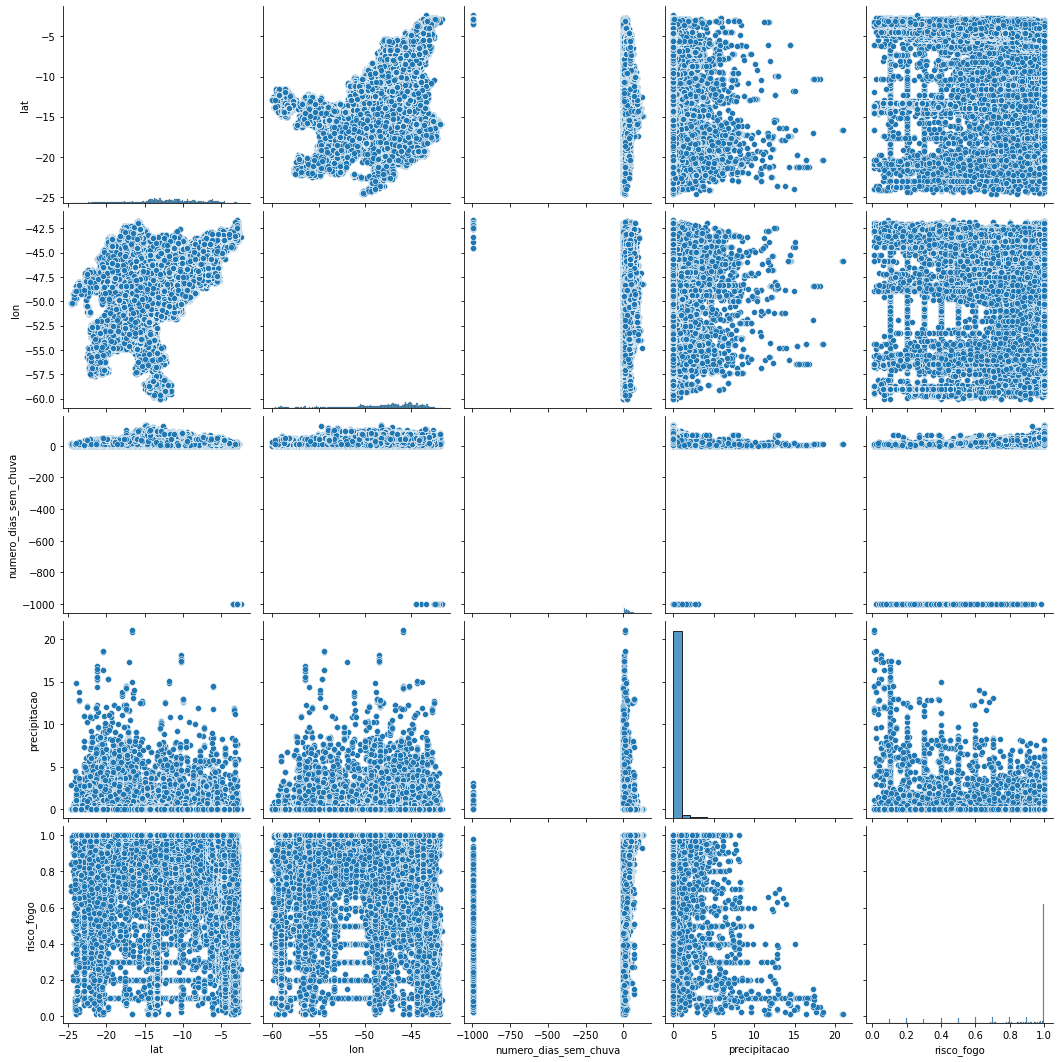

In [33]:
# Matriz de gráficos scatter 
sns.pairplot(meses, height=3);

# mostra o gráfico usando a função show() da matplotlib
plt.show()

In [34]:
# Matriz de covâriancia
mes_covariancia = meses.cov()

# Matriz de correlação
mes_correlacao = meses.corr()

print('Matriz de covariância: ')
display(mes_covariancia)

print('\n\nMatriz de correlação: ')
display(mes_correlacao)

Matriz de covariância: 


,lat,lon,numero_dias_sem_chuva,precipitacao,risco_fogo
lat,18.704230,7.814986,-21.447006,-0.283973,0.038809
lon,7.814986,16.108400,-17.293878,-0.100895,0.120263
numero_dias_sem_chuva,-21.447006,-17.293878,3662.068688,-1.421434,3.875388
precipitacao,-0.283973,-0.100895,-1.421434,0.374316,-0.036706
risco_fogo,0.038809,0.120263,3.875388,-0.036706,0.065202




Matriz de correlação: 


,lat,lon,numero_dias_sem_chuva,precipitacao,risco_fogo
lat,1.000000,0.450228,-0.081947,-0.107322,0.035142
lon,0.450228,1.000000,-0.071204,-0.041089,0.117348
numero_dias_sem_chuva,-0.081947,-0.071204,1.000000,-0.038392,0.250796
precipitacao,-0.107322,-0.041089,-0.038392,1.000000,-0.234956
risco_fogo,0.035142,0.117348,0.250796,-0.234956,1.000000


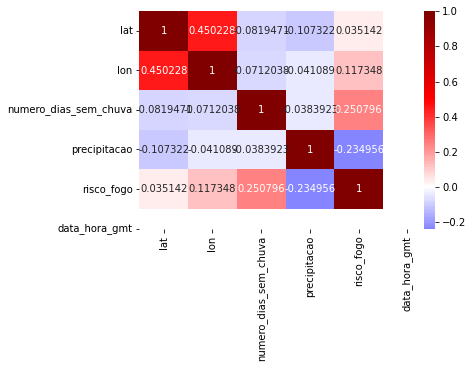

In [35]:
labs = ["lat", "lon", "numero_dias_sem_chuva", "precipitacao", "risco_fogo", "data_hora_gmt"]
sns.heatmap(mes_correlacao, annot=True, fmt='g', xticklabels=labs, yticklabels=labs, cmap='seismic', center = 0)
plt.show()

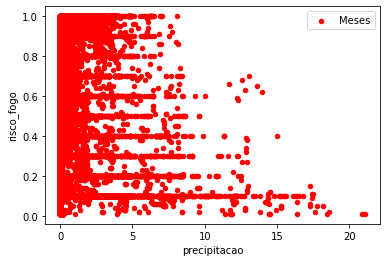

In [36]:
ax = meses.plot(kind='scatter', x="precipitacao", y="risco_fogo", color='Red', label="Meses")

plt.show()

<AxesSubplot:ylabel='Frequency'>

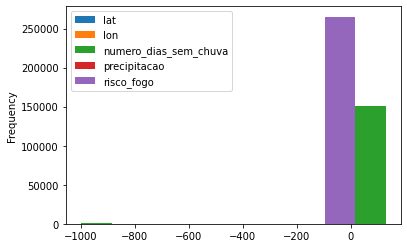

In [37]:
meses.plot(kind='hist')

# Bloco 2

In [38]:
TAMANHO_TESTE = 0.1 # fração de dados utilizada para teste: 10%
SEMENTE_ALEATORIA = 61455 # semente escolhida aleatoriamente
DATASET_NAME = "meses"
FEATURES = ["numero_dias_sem_chuva", "precipitacao", "lat", "lon"]
TARGET = ["risco_fogo"]

indices = meses.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

meses_treino = meses.loc[indices_treino]
meses_teste = meses.loc[indices_teste]

X_treino = meses_treino.reindex(FEATURES, axis=1).values
y_treino = meses_treino.reindex(TARGET, axis=1).values
X_teste = meses_teste.reindex(FEATURES, axis=1).values
y_teste = meses_teste.reindex(TARGET, axis=1).values

In [40]:
normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

MinMaxScaler()

## Baseline

In [41]:
# cria o modelo
modelo_baseline = DummyRegressor()
# treina o modelo
modelo_baseline.fit(normalizador_x.transform(X_treino),normalizador_y.transform(y_treino))

# realiza uma previsão usando o modelo treinado
previsao = modelo_baseline.predict(normalizador_x.transform(X_treino))
#previsao = normalizador_y.inverse_transform(previsao)
print(previsao)

[0.84847435 0.84847435 0.84847435 ... 0.84847435 0.84847435 0.84847435]


In [42]:
y_verdadeiro = y_teste
y_previsao = modelo_baseline.predict(normalizador_x.transform(X_teste))
#y_previsao = normalizador_y.inverse_transform(y_previsao)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo linear foi de {RMSE}")

O RMSE do modelo linear foi de 0.25423701029201057


# K-vizinhos mais próximos

In [43]:
# cria o modelo
modelo_knm = KNeighborsRegressor()

# treina o modelo
modelo_knm.fit(
    normalizador_x.transform(X_treino),
    normalizador_y.transform(y_treino),
)

# realiza uma previsão usando o modelo treinado
previsao = modelo_knm.predict(normalizador_x.transform(X_treino))
previsao = normalizador_y.inverse_transform(previsao)
print(previsao)

[[1.  ]
 [1.  ]
 [0.97]
 ...
 [1.  ]
 [0.98]
 [1.  ]]


In [44]:
NUM_VIZINHOS = [1, 5, 10]

for n in NUM_VIZINHOS:
    modelo_knn = KNeighborsRegressor(n_neighbors=n)

    modelo_knm.fit(normalizador_x.transform(X_treino),normalizador_y.transform(y_treino))
    y_verdadeiro = y_teste
    y_previsao = modelo_knm.predict(normalizador_x.transform(X_teste))
    y_previsao = normalizador_y.inverse_transform(y_previsao)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    print(f"O RMSE do modelo linear foi de {RMSE} com {n} vizinhos.")

O RMSE do modelo linear foi de 0.08759935110152076 com 1 vizinhos.
O RMSE do modelo linear foi de 0.08759935110152076 com 5 vizinhos.
O RMSE do modelo linear foi de 0.08759935110152076 com 10 vizinhos.


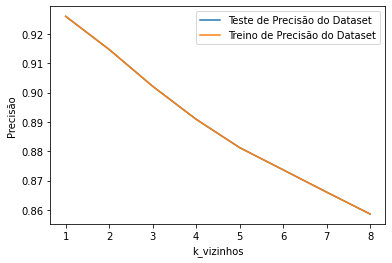

In [45]:
# Split into training and test set
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
 
# Loop over K values
for i, k in enumerate(neighbors):
    modelo_knm = KNeighborsRegressor(n_neighbors=k)
    modelo_knm.fit(normalizador_x.transform(X_treino),normalizador_y.transform(y_treino))

    # Compute training and test data accuracy
    train_accuracy[i] = modelo_knm.score(normalizador_x.transform(X_teste), normalizador_y.transform(y_teste))
    test_accuracy[i] = modelo_knm.score(normalizador_x.transform(X_teste), normalizador_y.transform(y_teste))
 
# Plot do Gráfico
plt.plot(neighbors, test_accuracy, label = 'Teste de Precisão do Dataset')
plt.plot(neighbors, train_accuracy, label = 'Treino de Precisão do Dataset')
 
plt.legend()
plt.xlabel('k_vizinhos')
plt.ylabel('Precisão')
plt.show()

# Modelo de Regressão Linear

In [46]:
# cria o modelo
modelo_linear = LinearRegression()

# treina o modelo
modelo_linear.fit(normalizador_x.transform(X_treino), normalizador_y.transform(y_treino))

# realiza uma previsão usando o modelo treinado
previsao = modelo_linear.predict(normalizador_x.transform(X_treino))
previsao = normalizador_y.inverse_transform(previsao)
print(previsao)

[[0.88141621]
 [0.81105356]
 [0.85321921]
 ...
 [0.8747693 ]
 [0.87064896]
 [0.88084116]]


In [47]:
y_verdadeiro = y_teste
y_previsao = modelo_linear.predict(normalizador_x.transform(X_teste))
y_previsao = normalizador_y.inverse_transform(y_previsao)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo linear foi de {RMSE}.")

O RMSE do modelo linear foi de 0.23769024621130785.


## Árvore de Decisão

In [48]:
# cria o modelo
modelo_dt = DecisionTreeRegressor(random_state=SEMENTE_ALEATORIA)

# treina o modelo
modelo_dt.fit(normalizador_x.transform(X_treino), normalizador_y.transform(y_treino))

# realiza uma previsão usando o modelo treinado
previsao = modelo_dt.predict(normalizador_x.transform(X_treino))
previsao = normalizador_y.inverse_transform(previsao)
print(previsao)

ValueError: Expected 2D array, got 1D array instead:
array=[1.         1.         0.96969697 ... 1.         1.         1.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
y_verdadeiro = y_teste
y_previsao = modelo_dt.predict(normalizador_x.transform(X_teste))
y_previsao = normalizador_y.inverse_transform(y_previsao)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo linear foi de {RMSE}.")

## Classificação
### com Floresta Aleatória

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
# cria o modelo
modelo_rf = RandomForestClassifier(random_state=SEMENTE_ALEATORIA)

# treina o modelo
modelo_rf.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_rf.predict(X_teste)
print(previsao)

TypeError: Singleton array array(LabelEncoder(), dtype=object) cannot be considered a valid collection.

#### Métricas:

In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [94]:
accuracy_score(y_test, y_pred)print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")

SyntaxError: invalid syntax (Temp/ipykernel_33004/574697489.py, line 1)

In [102]:
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color     plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24),
    plt.colorbar(aspect=4),
    tick_marks = np.arange(len(classes)),
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14),
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),
        range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
        fontsize = 20,
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"),
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [103]:
# Plotar como confusion_matrix(y_test, y_pred)
plot_confusion_matrix()

TypeError: plot_confusion_matrix() missing 2 required positional arguments: 'cm' and 'classes'

#### HIPERPARÂMETROS

In [ ]:
NUM_FOLHAS = [None, 6, 36]
NUM_PROFUNDIDADE = [None, 3, 10]

for n_folhas, n_profundidade in product(NUM_FOLHAS, NUM_PROFUNDIDADE):
    modelo_dt = DecisionTreeRegressor(
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=SEMENTE_ALEATORIA,
    )

    modelo_dt.fit(normalizador_x.transform(X_treino), normalizador_y.transform(y_treino))

    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(normalizador_x.transform(X_teste))
    y_previsao = normalizador_y.inverse_transform(y_previsao)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
        f"O RMSE do modelo AD usando max_leaf_nodes={n_folhas} "
        f"e max_depth={n_profundidade} foi de {RMSE:.2f}."
    )

#### GRAFO DO MODELO DE ÁRVORE DE DECISÕES

In [ ]:
# cria e treina o modelo
modelo_dt = DecisionTreeRegressor(
    max_leaf_nodes=6,
    random_state=SEMENTE_ALEATORIA,
)
modelo_dt.fit(normalizador_x.transform(X_treino), normalizador_y.transform(y_treino))

# cria os objetos de figura e eixo
fig, axe = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(7, 4),
    dpi=150,
)

# plota o grafo da árvore de decisão
tree.plot_tree(
    modelo_dt,
    feature_names=FEATURES,
    ax=axe,
    impurity=False,
    filled=True,
    proportion=True,
    precision=2,
)

# mostra o plot para o usuário
plt.show()